In [1]:
#IMPORTS

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
 

Using TensorFlow backend.


In [3]:
train_data = pd.read_csv('Google_Stock_Price_Train.csv')
test_data = pd.read_csv('Google_Stock_Price_Test.csv')

print(train_data.shape)
print(test_data.shape)

(1258, 6)
(20, 6)


In [4]:
train_data

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"


In [6]:
train_open = train_data.iloc[:, 1:2].values
scaler = MinMaxScaler()
train_open_scaled = scaler.fit_transform(train_open)

X_train = []
y_train = []
timesteps = 60

for i in range(timesteps, len(train_open)):
    X_train.append(train_open_scaled[i-timesteps:i, 0])
    y_train.append(train_open_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

print(X_train.shape, y_train.shape)

(1198, 60, 1) (1198,)


In [7]:
X_train

array([[[0.08581368],
        [0.09701243],
        [0.09433366],
        ...,
        [0.07846566],
        [0.08034452],
        [0.08497656]],

       [[0.09701243],
        [0.09433366],
        [0.09156187],
        ...,
        [0.08034452],
        [0.08497656],
        [0.08627874]],

       [[0.09433366],
        [0.09156187],
        [0.07984225],
        ...,
        [0.08497656],
        [0.08627874],
        [0.08471612]],

       ...,

       [[0.92106928],
        [0.92438053],
        [0.93048218],
        ...,
        [0.95475854],
        [0.95204256],
        [0.95163331]],

       [[0.92438053],
        [0.93048218],
        [0.9299055 ],
        ...,
        [0.95204256],
        [0.95163331],
        [0.95725128]],

       [[0.93048218],
        [0.9299055 ],
        [0.93113327],
        ...,
        [0.95163331],
        [0.95725128],
        [0.93796041]]])

In [5]:
X_train[0,:,:].shape

(60, 1)

In [6]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1:])))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)               

In [7]:
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
1198/1198 [==============================] - 8s 7ms/step - loss: 0.0408
Epoch 2/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0063
Epoch 3/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0056
Epoch 4/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0053
Epoch 5/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0057
Epoch 6/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0053
Epoch 7/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0051
Epoch 8/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0048
Epoch 9/100
1198/1198 [==============================] - 7s 5ms/step - loss: 0.0050
Epoch 10/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0053
Epoch 11/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0043
Epoch 12/100
1198/1198 [==============================] - 6s 5ms/step - lo

In [16]:
real_stock_price = test_data.iloc[:, 1:2].values

dataset_total = pd.concat((train_data['Open'], test_data['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test_data) - 60 : ].values.reshape(-1,1)

inputs_scaled = scaler.transform(inputs)

X_test = []
y_test = []
timesteps = 60

for i in range(timesteps, len(inputs_scaled)):
    X_test.append(inputs_scaled[i-timesteps:i, :])
    y_test.append(inputs_scaled[i, 0])
    
X_test, y_test = np.array(X_test), np.array(y_test)

In [17]:
predicted_stock_price = scaler.inverse_transform(model.predict(X_test))

Text(0,0.5,'Stock Price')

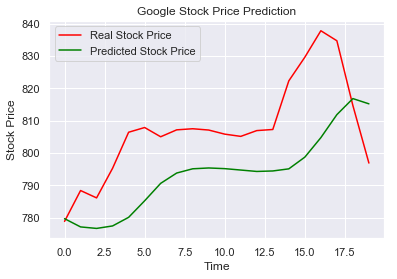

In [18]:
plt.plot(real_stock_price, color = "red", label = "Real Stock Price")
plt.plot(predicted_stock_price, color = "green", label = "Predicted Stock Price")
plt.legend()
plt.title("Google Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Stock Price")

In [252]:
def cvt_float(strin):
    if isinstance(strin, str):
        return float(strin.replace(',',''))

In [253]:
train_data['Close'] = train_data['Close'].apply(cvt_float)

In [271]:
train_cols = train_data.iloc[:, 1:5].as_matrix()
train_open = train_data.iloc[:,1:2].values
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_cols)
sc_predict = MinMaxScaler()
sc_predict.fit_transform(train_open)
X_train = []
y_train = []
timesteps = 60

for i in range(timesteps, len(train_open)):
    X_train.append(train_scaled[i-timesteps:i, :])
    y_train.append(train_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
#X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
# X_train = np.rollaxis(X_train, 1)
# X_train = np.rollaxis(X_train, 2,1)

print(X_train.shape, y_train.shape)

(1198, 60, 4) (1198,)


/Users/aakash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [324]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1:])))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.summary()

es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
tb = TensorBoard('logs')
customCallbacks = [es]


model.fit(X_train, y_train, callbacks = customCallbacks, epochs = 100, batch_size = 32)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_53 (LSTM)               (None, 60, 50)            11000     
_________________________________________________________________
dropout_53 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_54 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_54 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_55 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_55 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_56 (LSTM)               (None, 50)              

/Users/aakash/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1198/1198 [==============================] - 6s 5ms/step - loss: 0.0066
Epoch 3/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0054
Epoch 4/100
1198/1198 [==============================] - 5s 5ms/step - loss: 0.0060
Epoch 5/100
1198/1198 [==============================] - 5s 5ms/step - loss: 0.0050
Epoch 6/100
1198/1198 [==============================] - 5s 5ms/step - loss: 0.0043
Epoch 7/100
1198/1198 [==============================] - 5s 5ms/step - loss: 0.0045
Epoch 8/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0047
Epoch 9/100
1198/1198 [==============================] - 5s 5ms/step - loss: 0.0042
Epoch 10/100
1198/1198 [==============================] - 7s 6ms/step - loss: 0.0044
Epoch 11/100
1198/1198 [==============================] - 7s 6ms/step - loss: 0.0043
Epoch 12/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0043
Epoch 13/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0038


In [327]:
real_stock_price = test_data.iloc[:, 1:2].values

dataset_total = pd.concat((train_data, test_data), axis = 0)
dataset_total.drop(['Date', 'Volume'], axis = 1, inplace = True)

dataset_total = dataset_total[len(dataset_total) - len(test_data) - 60 : ].as_matrix()


dataset_scaled = scaler.transform(dataset_total)
X_test = []
y_test = []
timesteps = 60

for i in range(timesteps, len(dataset_scaled)):
    X_test.append(dataset_scaled[i-timesteps:i, :])
    y_test.append(dataset_scaled[i, 0])
    
X_test, y_test = np.array(X_test), np.array(y_test)
#X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(X_test.shape, y_test.shape)


(20, 60, 4) (20,)


/Users/aakash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [328]:
predicted_stock_price = sc_predict.inverse_transform(model.predict(X_test))

In [329]:
sc_predict.inverse_transform(model.predict(X_test))

array([[776.9091 ],
       [776.1459 ],
       [778.5035 ],
       [781.41565],
       [785.8857 ],
       [790.389  ],
       [792.3412 ],
       [792.09955],
       [791.12787],
       [792.17053],
       [792.5155 ],
       [792.6224 ],
       [792.9552 ],
       [793.46326],
       [796.22644],
       [801.5402 ],
       [807.6709 ],
       [811.09485],
       [810.7562 ],
       [802.7869 ]], dtype=float32)

In [330]:
real_stock_price

array([[778.81],
       [788.36],
       [786.08],
       [795.26],
       [806.4 ],
       [807.86],
       [805.  ],
       [807.14],
       [807.48],
       [807.08],
       [805.81],
       [805.12],
       [806.91],
       [807.25],
       [822.3 ],
       [829.62],
       [837.81],
       [834.71],
       [814.66],
       [796.86]])

Text(0,0.5,'Stock Price')

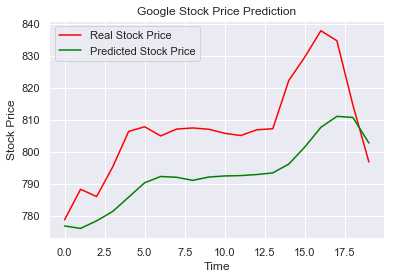

In [331]:
plt.plot(real_stock_price, color = "red", label = "Real Stock Price")
plt.plot(predicted_stock_price, color = "green", label = "Predicted Stock Price")
plt.legend()
plt.title("Google Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Stock Price")